# [타이타닉 생존자 예측](https://www.kaggle.com/c/titanic)
머신러닝에 배우고 나서 처음으로 시작한 연습용 프로젝트이다. 기본적인 회귀분석보다 부스팅 알고리즘의 정확성 차이를 알고 싶어서 진행하였고 전처리에 대한 중요성을 깨닫게 되었다.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DongChanKIM2/Kaggle_Struggle/blob/main/Titanic.ipynb)

## 라이브러리 생성

In [1]:
import pandas as pd # csv 파일을 읽어오고 데이터 처리를mport pandas as pd # csv 파일을 읽어오고 데이터 처리를
from pandas import DataFrame # 데이터를 표 처리 해주기 위해서
import numpy as np # 수학 계산을 위해서

!pip install lightgbm # lgbm 사용을 위해서 
import lightgbm as lgb
from lightgbm import LGBMRegressor
from lightgbm import LGBMClassifier

from sklearn.metrics import roc_auc_score, roc_curve # 평가지표
from sklearn.model_selection import train_test_split # train:test split

%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats

In [ ]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [ ]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

생존자/사망자 PLOT 생성

In [ ]:
def bar_chart(feature):
    survived = train[train['Survived']==1][feature].value_counts()
    dead = train[train['Survived']==0][feature].value_counts()
    df = pd.DataFrame([survived,dead])
    df.index = ['Survived','Dead']
    df.plot(kind='bar',stacked=True, figsize=(10,5))


정확성 향상을 위해 train, test 파일 병합

In [ ]:
train_test_data=[train, test]

for dataset in train_test_data:
    dataset['Title']=dataset['Name'].str.extract('([A-za-z]+)\.', expand=False)

train.head()
train.drop('Name',axis=1,inplace=True)
test.drop('Name',axis=1,inplace=True)

In [ ]:
train['Title'].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Mlle          2
Major         2
Capt          1
Mme           1
Sir           1
Don           1
Ms            1
Jonkheer      1
Countess      1
Lady          1
Name: Title, dtype: int64

In [ ]:
test['Title'].value_counts()

Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Rev         2
Ms          1
Dr          1
Dona        1
Name: Title, dtype: int64

## Object Type의 변수들을 one hot encoding 기법을 통해 숫자로 변환

In [ ]:
title_mapping={"Mr":0, "Miss":1, "Mrs":2,
                "Master":3, "Dr":3, "Rev":3, "Col": 3, 'Ms': 3, 'Mlle': 3, "Major": 3, 'Lady': 3, 'Capt': 3,
                 'Sir': 3, 'Don': 3, 'Mme':3, 'Jonkheer': 3, 'Countess': 3 }
for dataset in train_test_data:
    dataset['Title']=dataset['Title'].map(title_mapping) #map: 덮어 씌우기
train_test_data

[     PassengerId  Survived  Pclass     Sex   Age  SibSp  Parch  \
 0              1         0       3    male  22.0      1      0   
 1              2         1       1  female  38.0      1      0   
 2              3         1       3  female  26.0      0      0   
 3              4         1       1  female  35.0      1      0   
 4              5         0       3    male  35.0      0      0   
 ..           ...       ...     ...     ...   ...    ...    ...   
 886          887         0       2    male  27.0      0      0   
 887          888         1       1  female  19.0      0      0   
 888          889         0       3  female   NaN      1      2   
 889          890         1       1    male  26.0      0      0   
 890          891         0       3    male  32.0      0      0   
 
                Ticket     Fare Cabin Embarked  Title  
 0           A/5 21171   7.2500   NaN        S      0  
 1            PC 17599  71.2833   C85        C      2  
 2    STON/O2. 3101282   7

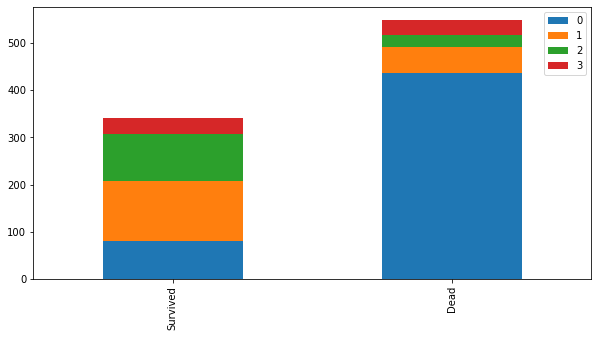

In [ ]:
bar_chart('Title')

In [ ]:
sex_mapping = {"male": 0, "female":1}
for dataset in train_test_data:
    dataset['Sex'] = dataset['Sex'].map(sex_mapping)
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,0,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,1,1,38.0,1,0,PC 17599,71.2833,C85,C,2
2,3,1,3,1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,1,1,35.0,1,0,113803,53.1000,C123,S,2
4,5,0,3,0,35.0,0,0,373450,8.0500,NaN,S,0


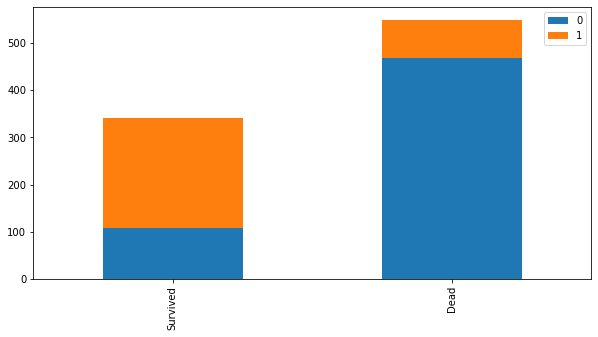

In [ ]:
# 성별에 따른 생존률 비교
bar_chart('Sex')

In [ ]:
#결측치를 해당 그룹의 평균값으로 대체하기
train['Age'].fillna(train.groupby('Title')['Age'].transform('median'),inplace=True)
test['Age'].fillna(test.groupby('Title')['Age'].transform('median'),inplace=True)

In [ ]:
for dataset in train_test_data:
    dataset['Embarked']=dataset['Embarked'].fillna('S')

In [ ]:
test["Fare"].fillna(test.groupby('Pclass')['Fare'].transform('median'), inplace=True)

In [ ]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,0,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,1,1,38.0,1,0,PC 17599,71.2833,C85,C,2
2,3,1,3,1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,1,1,35.0,1,0,113803,53.1000,C123,S,2
4,5,0,3,0,35.0,0,0,373450,8.0500,NaN,S,0


In [ ]:
train.drop('Ticket',axis=1,inplace=True)
test.drop('Ticket',axis=1,inplace=True)
train.drop('Cabin',axis=1,inplace=True)
test.drop('Cabin',axis=1,inplace=True)

In [ ]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Sex              int64
Age            float64
SibSp            int64
Parch            int64
Fare           float64
Embarked        object
Title            int64
dtype: object

In [ ]:
for dataset in train_test_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

In [ ]:
Pclass1 = train[train['Pclass']==1]['Embarked'].value_counts()
Pclass2 = train[train['Pclass']==2]['Embarked'].value_counts()
Pclass3 = train[train['Pclass']==3]['Embarked'].value_counts()
df = pd.DataFrame([Pclass1, Pclass2, Pclass3])
df.index = ['1st class', '2nd class', '3rd class']

In [ ]:
embarked_mapping = {'S':0, 'C':1, 'Q':2}
for dataset in train_test_data:
    dataset['Embarked'] = dataset['Embarked'].map(embarked_mapping)

In [ ]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Sex              int64
Age            float64
SibSp            int64
Parch            int64
Fare           float64
Embarked         int64
Title            int64
dtype: object

In [ ]:
train.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
Title          0
dtype: int64

## LGBM 파라미터 설정 및 F1 Score 확인

In [ ]:
param = {'boosting_type': 'gbdt','num_leaves':10, 'objective':'binary','max_depth':10,'learning_rate':.05} 
#max_depth, learning rate높이면 과적화,but 변수가 너무 많으면 max_depth 증가(20~30)
param['metric'] = ['auc', 'binary'] #auc가 auccray가 아니라 auc 면적, 지금은 y값이 0,1이라 binary이지만 y값이 2이상이면 다항분포 사용
num_boost_round = 100
early_stopping_rounds = 30 #30번부터 차이가 없으면 30번 이후에서 끝내기
evals_result = {}
num_round = num_boost_round

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.3)
train_data=lgb.Dataset(x_train,y_train) #label:lgb.dataset함수 내부에 y값 라벨링된 종속변수 의미
lgbm=lgb.train(param,train_data,num_round)
ypred=lgbm.predict(x_test)

In [ ]:
ypred_result=ypred 
#F1 Score맞추기 위해서 하는 것, 모델 2개를 비교할땐 auc,
#여기의 auc는 다 영역임, but 0이 9개 ,1이 1개이면 전부 0이어도 정확성이 높게 나오므로 F1 score로 검증
for i in range(0,1):
    for j in range(0,len(ypred)):
        #0,1 맞추을 마주는 비율이 거의 같아지는 cut off 값을 찾아서 적용
        if ypred[j]>0.39:
            ypred_result[j]=1
        else:
            ypred_result[j]=0

pred_prob=pd.DataFrame(ypred)
pred_result=pd.DataFrame(ypred_result)

print("Crosstab")
print(pd.crosstab(ypred_result,y_test))

Crosstab
Survived    0   1
row_0            
0.0       140  29
1.0        18  81


In [ ]:
arr=pd.crosstab(y_test,ypred_result).to_numpy()
TN=arr[0][0]
TP=arr[1][1]
FN=arr[1][0]
FP=arr[0][1]
recall=TP/(TP+FN)
precision=TP/(TP+FP)
zero=TN/(TN+FP)
f1score=(precision*recall*2)/(precision+recall)

print("0,1 맞추는 비율 (1에 가까워야 0,1 모두 잘 맞추는 결과)")
print(recall/zero)
print("recall")     
print(recall)
print("precision")     
print(precision)

print("f1score")
print(f1score)

0,1 맞추는 비율 (1에 가까워야 0,1 모두 잘 맞추는 결과)
0.831038961038961
recall
0.7363636363636363
precision
0.8181818181818182
f1score
0.7751196172248803


In [ ]:
pred_result.to_csv('predict.csv')